<a href="https://colab.research.google.com/github/SSDivyaRavali/CDS/blob/main/Module4/Video_Classification_with_custom_generators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification 

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:

 

*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below. 

![img](http://www.nada.kth.se/cvap/actions/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:** 

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN; 
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file; 
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability; 
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [ ]:
import keras
from keras.models import load_model
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras
# TensorFlow 
import tensorflow as tf
# Some modules to display an animation using imageio.
import imageio
from IPython import display

seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from sklearn.utils import shuffle
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import np_utils
%matplotlib inline

A video consists of an ordered sequence of frames. Each frame contains spatial information, and the sequence of those frames contains temporal information. To model both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing). Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of GRU layers. This kind of hybrid architecture is popularly known as a CNN-RNN.

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
root_dir = '/content/Actions'
dest_dir = '/content/activity_data'
if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

In [ ]:
data_dir_list = os.listdir(root_dir)
data_dir_list

['test', 'train']

In [ ]:
train_data_path = "/content/Actions/train/"
test_data_path = "/content/Actions/test/"
classes_names = os.listdir(train_data_path)
classes_names

['running', 'Handclapping', 'boxing', 'Walking', 'jogging', 'handwaving']

In [ ]:
num_classes=6
labels_to_class = {0:'Walking', 1:'boxing', 2:'handwaving', 3:'Handclapping', 4:'running', 5:'jogging'}
class_to_labels = {'Walking':0, 'boxing':1, 'handwaving':2, 'Handclapping':3, 'running':4, 'jogging':5}
resize = 120	
num_epochs =10
batch_size =10
FRAMES_PER_VIDEO = 200

In [ ]:
root_data_dir = '/content/activity_data'
# Loop over every activity category in train and test 
train_data_path = os.path.join('/content/activity_data','train')
test_data_path = os.path.join('/content/activity_data','test')

In [ ]:
  from google.colab.patches import cv2_imshow

In [ ]:
#@title Path to write frame
def vid_to_frames():
    for data_dir in data_dir_list: # read the train and test directory one by one
        data_path = os.path.join(root_dir,data_dir) # '/content/Actions/train'
        dest_data_path = os.path.join(dest_dir,data_dir) # 'activity_data/train'
        if not os.path.exists(dest_data_path):
            os.mkdir(dest_data_path)
        
        activity_list = os.listdir(data_path) # thre activity directories ['Handclapping', 'handwaving', 'Walking', 'running', 'boxing', 'jogging'
        
        for activity in activity_list: # loop over every activity folder
            activity_path = os.path.join(data_path,activity) # '/content/Actions/train/jogging'
            dest_activity_path = os.path.join(dest_data_path,activity) # '/content/activity_data/train/walking'
            if not os.path.exists(dest_activity_path):
                os.mkdir(dest_activity_path)
            write_frames(activity_path,dest_activity_path)

In [ ]:
def write_frames(activity_path, dest_activity_path):
    # read the list of video from '/content/Actions/train/jogging' -
    # [person01_handclapping_d1_uncomp.avi,v_walking_g01_c01.avi,v_walking_g01_c01.avi, ......]

    vid_list = os.listdir(activity_path)
    for vid in vid_list:
        dest_folder_name = vid[:-4]
        # 'activity_data/train/Walking/person01_walking_d1_uncomp.avi'
        dest_folder_path = os.path.join(dest_activity_path, dest_folder_name)
        if not os.path.exists(dest_folder_path):
            os.mkdir(dest_folder_path)

        video_path = os.path.join(activity_path, vid)
        print('video path: ', video_path)

        frame_ids = []
        vidObj = cv2.VideoCapture(video_path)
        total_frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
        start = 0
        if total_frames > 2 * FRAMES_PER_VIDEO:
            start = np.random.randint(0, total_frames - 2 * FRAMES_PER_VIDEO)
            frame_ids = range(start, start + 2 * FRAMES_PER_VIDEO, 2)
        else:
            vidObj.release()
            cv2.destroyAllWindows()
            return None

        out = []
        for frame_id in frame_ids:
            #vidObj.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
            success, video_image = vidObj.read()

            if video_image is not None:
                output_file_name = 'img_{:06d}'.format(frame_id) + '.png'  # img_000001.png
                # output frame to write 'activity_data/train/walking/v_walking_g01_c01/img_000001.png'
                output_file_path = os.path.join(dest_folder_path, output_file_name)

                cv2.imwrite(output_file_path, video_image)  # writing frames to defined location

        vidObj.release()
        cv2.destroyAllWindows()

In [ ]:
vid_to_frames()

video path:  /content/Actions/test/running/person16_running_d1_uncomp.avi
video path:  /content/Actions/test/Handclapping/person14_handclapping_d2_uncomp.avi
video path:  /content/Actions/test/Handclapping/person19_handclapping_d3_uncomp.avi
video path:  /content/Actions/test/Handclapping/person17_handclapping_d1_uncomp.avi
video path:  /content/Actions/test/Handclapping/person14_handclapping_d3_uncomp.avi
video path:  /content/Actions/test/Handclapping/person16_handclapping_d4_uncomp.avi
video path:  /content/Actions/test/boxing/person13_boxing_d4_uncomp.avi
video path:  /content/Actions/test/boxing/person03_boxing_d3_uncomp.avi
video path:  /content/Actions/test/boxing/person03_boxing_d1_uncomp.avi
video path:  /content/Actions/test/boxing/person08_boxing_d3_uncomp.avi
video path:  /content/Actions/test/boxing/person05_boxing_d4_uncomp.avi
video path:  /content/Actions/test/boxing/person09_boxing_d1_uncomp.avi
video path:  /content/Actions/test/boxing/person11_boxing_d1_uncomp.avi
vi

In [ ]:
root_data_dir = '/content/activity_data'
# Loop over every activity category in train and test 
train_data_path = os.path.join('activity_data','train')
test_data_path = os.path.join('activity_data','test')

In [ ]:
# Assigning labels to each activity category
num_classes = 6
labels_name={'Walking':0, 'boxing':1, 'handwaving':2, 'Handclapping':3, 'running':4, 'jogging':5}

In [ ]:
#root_data_dir = '/content/gdrive/MyDrive/Projects/Video_Classification/activity_data'
# Loop over every activity category in train and test 
#train_data_path = os.path.join('/content/gdrive/MyDrive/Projects/Video_Classification/activity_data','train')
#test_data_path = os.path.join('/content/gdrive/MyDrive/Projects/Video_Classification/activity_data','test')

In [ ]:
data_dir_list = os.listdir(train_data_path)
data_dir_list

['running', 'Handclapping', 'boxing', 'Walking', 'jogging', 'handwaving']

In [ ]:
if not os.path.exists('data_files'):
    os.mkdir('data_files')
if not os.path.exists('data_files/train'):
    os.mkdir('data_files/train') 
if not os.path.exists('data_files/test'):
    os.mkdir('data_files/test')  

Create csv file for training data

In [ ]:
data_dir_list = os.listdir(train_data_path)
for data_dir in data_dir_list: # looping over every activity
    label = labels_name[str(data_dir)]
    video_list = os.listdir(os.path.join(train_data_path,data_dir))
    for vid in video_list: # looping over every video within an activity
        train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
        img_list = os.listdir(os.path.join(train_data_path,data_dir,vid))
        for img in img_list:# looping over every frame within the video
            img_path = os.path.join(train_data_path,data_dir,vid,img)
            train_df = train_df.append({'FileName': img_path, 'Label': label,'ClassName':data_dir },ignore_index=True)
        file_name='{}_{}.csv'.format(data_dir,vid)
        train_df.to_csv('data_files/train/{}'.format(file_name))

In [ ]:
data_dir_list = os.listdir(test_data_path)
for data_dir in data_dir_list: # looping over every activity
    label = labels_name[str(data_dir)]
    video_list = os.listdir(os.path.join(test_data_path,data_dir))
    for vid in video_list: # looping over every video within an activity
        test_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
        img_list = os.listdir(os.path.join(test_data_path,data_dir,vid))
        for img in img_list: # looping over every frame within the video
            img_path = os.path.join(test_data_path,data_dir,vid,img)
            test_df = test_df.append({'FileName': img_path, 'Label': label,'ClassName':data_dir },ignore_index=True)
        file_name='{}_{}.csv'.format(data_dir,vid)
        test_df.to_csv('data_files/test/{}'.format(file_name))

We are going to use data_files to read the path and activity_data to read the data from

#Writing the Data Generator 


spatial dimension i.e its spatial size(say 160 x 120).Need to incorporate the temporal dimension i.e. the number of frames you wish to feed once.
Temporal stride.... Let’s understand this with an example- say we have video with 50 frames.say you chose a temporal dimension of 16 and temporal stride of 4The how many data samples can be prepared from this video.If you choose a temporal stride of 4 then the number of data samples that we can get is 9. The first sample will be frame 1 to frame 16, the next will be from frame 5 to frame 21, the nest from frame 9 to 25 and so on.


total_images = 50 ; temporal_length = 16 ; temporal_stride = 1
num_samples = int((total_images-temporal_length)/temporal_stride)+1
num_samples = int((50-16)/1) + 1 = int(34)+1 = 35

total_images = 50 ; temporal_length = 30 ; temporal_stride = 4 num_samples = int((total_images-temporal_length)/temporal_stride)+1 num_samples = int((50-30)/4) + 1 = int(5)+1 = 6

For now we will not consider temporal padding i.e if number of frames in a video is less than the temporal_length we will drop that video from our data-set. For instance if temporal_length was 16 and number of frames in video is less than 16 (say even 15) , we will drop this video.

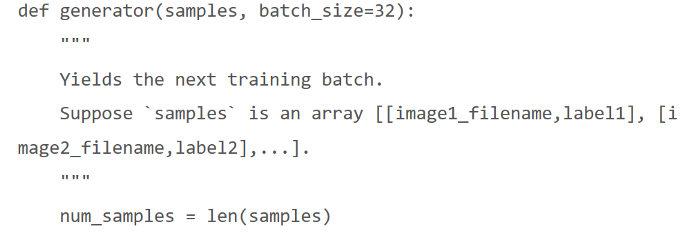

create the samples which consist of the sequence of filenames along with the label of that sequence. For a temporal dimension of 16 our samples list should be of format as

samples — [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].

# Custom data generator for loading video data for action recognition
A helper function for loading the samples in the format of
[[[frame1_filename,frame2_filename,…],label1], [[frame1_filename,frame2_filename,…],label2],……….]
[link text](http://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/)

In [ ]:
# Load the samples and their corresponding label for each video
def load_samples(data_cat='train',temporal_stride=4,temporal_length=16):
    data_path = os.path.join('data_files',data_cat)
    data_files = os.listdir(data_path)
    # define a generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            data_list.append([x,y])
        except Exception as e:
            print ('the exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

In [ ]:
# reading the video files from the csv file
def file_generator(data_path,data_files,temporal_stride=4,temporal_length=16):
    '''
    data_files - list of csv files to be read.
    '''
    for f in data_files: # read all the csv files (one csv file corresponds to one vdieo) in data_files one by one
        tmp_df = pd.read_csv(os.path.join(data_path,f))
        label_list = list(tmp_df['Label'])  # Load all the labels in the label_list
        total_images = len(label_list) 
        if total_images>=temporal_length: # only if the number of frames in the video is greater tha temporal length, use that video
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            print ('num of samples from vid seq-{}: {}'.format(f,num_samples))
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames are less than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(f))
            continue

        start_frame = 0
        samples = deque() # initliaze a queue to store the frames 
        samp_count=0 # a counter to count the number of smaple. one smaple has as many frames as defined by temporal length
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: #if the queue has as many frames as temporal length, return it as one sample
                samples_c=copy.deepcopy(samples) # copy the queue as in the next stage frames would be popped
                samp_count+=1
                for t in range(temporal_stride): # pop out as many frames as described by the stride from the left to accomodate new frames
                    samples.popleft()
                yield samples_c,label_list[0] # return a sample(consisting of as many frames as defined by temporal length) 
                                                # and its corsponding label

A load function for loading the samples in the format of
[[[frame1_filename,frame2_filename,…],label1], [[frame1_filename,frame2_filename,…],label2],……….]

# load the train data


In [ ]:
train_data = load_samples(data_cat='train',temporal_stride=4,temporal_length=16)

num of samples from vid seq-handwaving_person22_handwaving_d1_uncomp.csv: 47
num of frames is less than temporal length; hence discarding this file-running_person24_running_d4_uncomp.csv
num of frames is less than temporal length; hence discarding this file-Handclapping_person02_handclapping_d2_uncomp.csv
num of samples from vid seq-Walking_person25_walking_d4_uncomp.csv: 47
num of samples from vid seq-Walking_person19_walking_d3_uncomp.csv: 47
num of samples from vid seq-Walking_person01_walking_d4_uncomp.csv: 47
num of samples from vid seq-Walking_person05_walking_d2_uncomp.csv: 47
num of samples from vid seq-Walking_person02_walking_d1_uncomp.csv: 47
num of samples from vid seq-Walking_person12_walking_d1_uncomp.csv: 47
num of samples from vid seq-handwaving_person24_handwaving_d4_uncomp.csv: 47
num of samples from vid seq-Handclapping_person20_handclapping_d2_uncomp.csv: 47
num of samples from vid seq-handwaving_person13_handwaving_d4_uncomp.csv: 47
num of samples from vid seq-Walk

In [ ]:
print ('Total number of train samples:',len(train_data))
train_data[123]

Total number of train samples: 1833


[['activity_data/train/Walking/person19_walking_d3_uncomp/img_000286.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000338.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000142.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000016.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000322.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000066.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000154.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000226.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000258.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000354.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000050.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000318.png',
  'activity_data/train/Walking/person19_walking_d3_uncomp/img_000366.png',
  'activity_data/train/Wa

In [ ]:
#Load the test data
test_data = load_samples(data_cat='test',temporal_stride=4)
print ('Total number of test samples:',len(test_data))

num of samples from vid seq-handwaving_person08_handwaving_d1_uncomp.csv: 47
num of samples from vid seq-Walking_person18_walking_d2_uncomp.csv: 47
num of frames is less than temporal length; hence discarding this file-boxing_person11_boxing_d1_uncomp.csv
num of samples from vid seq-Walking_person07_walking_d2_uncomp.csv: 47
num of samples from vid seq-handwaving_person05_handwaving_d1_uncomp.csv: 47
num of samples from vid seq-Handclapping_person17_handclapping_d1_uncomp.csv: 47
num of samples from vid seq-Walking_person05_walking_d1_uncomp.csv: 47
num of samples from vid seq-boxing_person03_boxing_d3_uncomp.csv: 47
num of samples from vid seq-boxing_person08_boxing_d3_uncomp.csv: 47
num of samples from vid seq-Walking_person21_walking_d3_uncomp.csv: 47
num of samples from vid seq-handwaving_person13_handwaving_d1_uncomp.csv: 47
num of samples from vid seq-Walking_person10_walking_d3_uncomp.csv: 47
num of samples from vid seq-handwaving_person16_handwaving_d1_uncomp.csv: 47
num of sam

In [ ]:
#Shuffle the dataset
def shuffle_data(samples):
    data = shuffle(samples,random_state=2)
    return data
def preprocess_image(img):
    img = cv2.resize(img,(120,120))
    img = img/255
    return img

In [ ]:
def data_generator(data,batch_size=10,temporal_padding='same',shuffle=True):              
    """
    Yields the next training batch.
    data is an array [[img1_filename,img2_filename...,img16_filename],label1], [image2_filename,label2],...].
    """
    num_samples = len(data)
    if shuffle:
        data = shuffle_data(data)
    while True:   
        for offset in range(0, num_samples, batch_size):
            print ('startring index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for batch_sample in batch_samples: # Loop over every batch
                # Load image (X)
                x = batch_sample[0]
                y = batch_sample[1]
                temp_data_list = []
                for img in x:
                    try:
                        img = cv2.imread(img)
                        #apply any kind of preprocessing here
                        #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                        img = preprocess_image(img)
                        temp_data_list.append(img)

                    except Exception as e:
                        print (e)
                        print ('error reading file: ',img)                      
                # Read label (y)
                #label = label_names[y]
                # Add example to arrays
                X_train.append(temp_data_list)
                y_train.append(y)
    
            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            # convert to one hot encoding for training keras model
            y_train = np_utils.to_categorical(y_train, 6)
    
            # yield the next training batch            
            yield X_train, y_train

create a generator object with training data


In [ ]:
train_generator = data_generator(train_data,batch_size=10,shuffle=True)


In [ ]:
test_generator = data_generator(test_data,batch_size=10,shuffle=True)


In [ ]:
x,y = next(train_generator)
print ('x shape: ',x.shape)
print ('y shape: ',y.shape)

startring index:  0
x shape:  (10, 16, 120, 120, 3)
y shape:  (10, 6)


In [ ]:
y #label

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
sample = x[2]
sample.shape

(16, 120, 120, 3)

In [ ]:
labels_to_class

{0: 'Walking',
 1: 'boxing',
 2: 'handwaving',
 3: 'Handclapping',
 4: 'running',
 5: 'jogging'}

In [ ]:
x_0=x[2]
y_0=y[2]
print('x_0 shape: ',x_0.shape)
print('y_0 shape: ',y_0.shape)

x_0 shape:  (16, 120, 120, 3)
y_0 shape:  (6,)


In [ ]:
activity = labels_to_class[np.argmax(y_0)]
activity

'Walking'

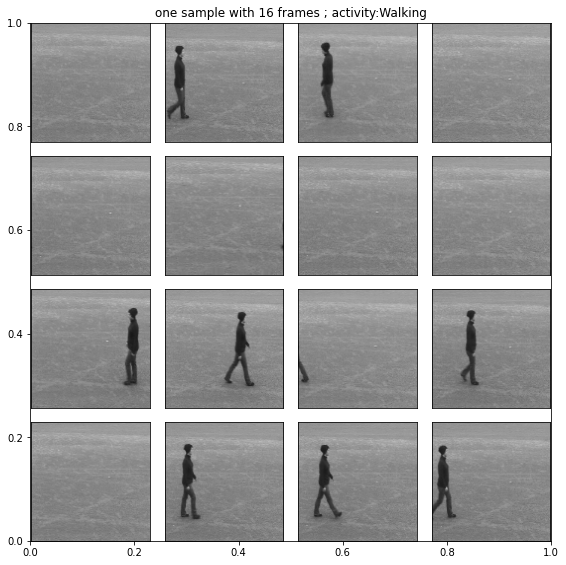

In [ ]:
num_of_images=16
fig=plt.figure(figsize=(8,8))	
plt.title("one sample with {} frames ; activity:{}".format(num_of_images,activity))
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(int(num_of_images)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(x_0[i,:,:,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
print('num of train_samples: {}'.format(len(train_data)))
print('num of test_samples: {}'.format(len(test_data)))

num of train_samples: 1833
num of test_samples: 2115


In [ ]:
def get_model(num_classes=6):
    # Define model
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(
        16,64,64,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(), metrics=['accuracy'])
    model.summary()
    #plot_model(model, show_shapes=True,
    #           to_file='model.png')
    return model

In [ ]:
model = get_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 64, 64, 32)    2624      
                                                                 
 activation_5 (Activation)   (None, 16, 64, 64, 32)    0         
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 64, 64, 32)    27680     
                                                                 
 activation_6 (Activation)   (None, 16, 64, 64, 32)    0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 22, 22, 32)    0         
 3D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 22, 22, 32)     0         
                                                      

understanding the input size of the model:
Keras provides ConvLSTM2D for ConvLSTM,it takes 5D tensor as the input and based on the channel argument position there are two ways to provide inputs.
1 sample consist of sequence of 70 images (equal to the seq_len) and each image is 120×120 (img_height, img_width) and 3 channel (RGB)

ConvLSTM based model design
In the ConvLSTM2D we are giving inputs of shape (70, 160, 120, 3) and the entire set of samples will be divided based on input shape.setting return_sequnce=False, because of this ConvLSTM will give output only after the last timestamp and not for every timestamp

#### Setup the parameters and train the model with epochs, batch wise 

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# Note: There will be a high memory requirement for the training steps below. 
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.optimizers import Nadam

In [ ]:
frames=16
channels=3
rows=120
columns=120
classes= 6


video = Input(shape=(frames,
                     rows,
                     columns, channels))
cnn_base = VGG16(input_shape=(rows,columns,channels),weights=None,include_top=False)

cnn_out = GlobalAveragePooling2D()(cnn_base.output)
print(cnn_base.summary())
print("----------------------------------")
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable =False
print(cnn.summary())
print("----------------------------------")

encoded_frames = TimeDistributed(cnn)(video)
print(encoded_frames)
encoded_sequence = LSTM(256)(encoded_frames)
# Create the dropout layers
dropout1 = Dropout(0.2)(encoded_sequence)
#flatten=Flatten()
hidden_layer = Dense(units=1024, activation="relu")(dropout1)
dropout2 = Dropout(0.3)(hidden_layer)
hidden_layer1 = Dense(units=512, activation="relu")(dropout2)
hidden_layer2 = Dense(units=256, activation="relu")(hidden_layer1)
hidden_layer3 = Dense(units=6, activation="relu")(hidden_layer2)
outputs = Dense(units=classes, activation="softmax")(hidden_layer2)
model = Model([video], outputs)
model.summary()

optimizer = Nadam(learning_rate=0.002,beta_1=0.9,beta_2=0.999,epsilon=1e-08,schedule_decay=0.004)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"]) 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

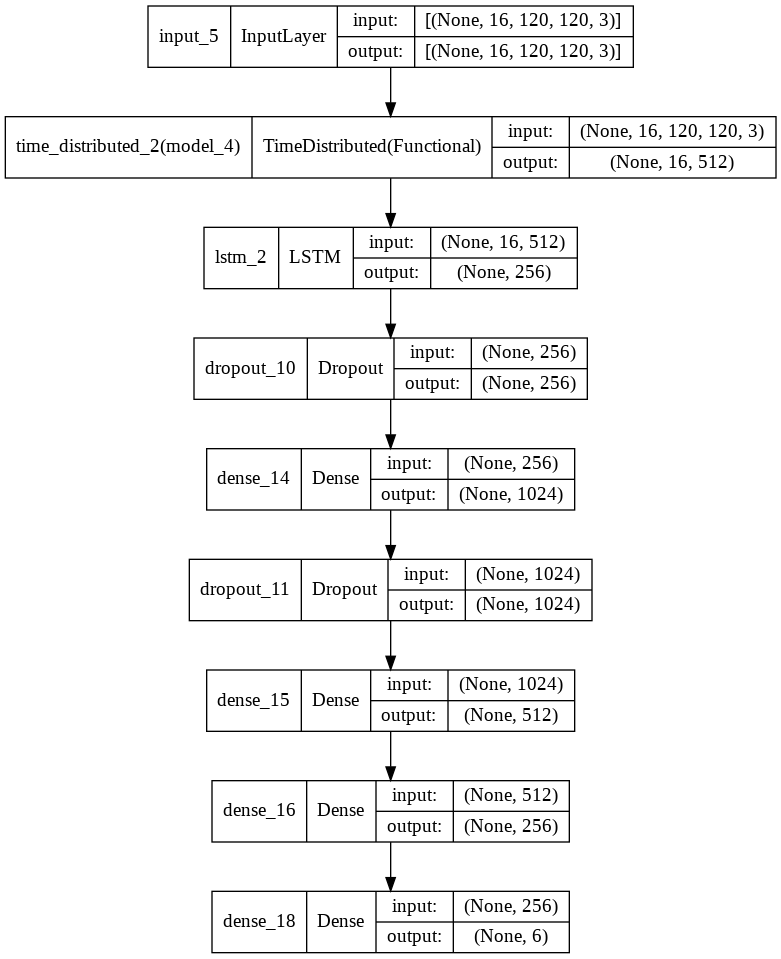

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='vgg.png',show_shapes=True)
from IPython.display import Image
Image("vgg.png")

In [ ]:
# Fit model using generator
hist = model.fit_generator(train_generator, 
                steps_per_epoch=len(train_data),epochs=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


startring index:  50
Epoch 1/3
startring index:  60
  32/1833 [..............................] - ETA: 10:04:00 - loss: 1.3056 - categorical_accuracy: 0.5938startring index:  380


KeyboardInterrupt: ignored

In [ ]:

# Fit model using generator
hist = model.fit(train_generator, 
                steps_per_epoch=len(train_data),epochs=3,shuffle=True)

startring index:  390
Epoch 1/3
startring index:  400
  50/1833 [..............................] - ETA: 9:55:47 - loss: 1.2312 - categorical_accuracy: 0.5540startring index:  900


KeyboardInterrupt: ignored

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:

# Fit model using generator
hist = model.fit(test_generator, 
                steps_per_epoch=len(train_data),epochs=3,shuffle=True)

startring index:  0
Epoch 1/3
startring index:  10
  29/1833 [..............................] - ETA: 10:01:16 - loss: 1.2973 - categorical_accuracy: 0.4207startring index:  300


In [ ]:
# YOUR CODE HERE

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification